In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/CS224W_project")
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


In [3]:
!ls

dataset.py  GVision_project.ipynb  KITTI  KITTI-350  project_GAN.py  project_model.py  __pycache__


In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data


def feature_map_to_graph(feature_map):
    batch_size, channels, height, width = feature_map.size()
    num_nodes = height * width

    x = feature_map.view(batch_size, channels, num_nodes).permute(0, 2, 1)  # (batch_size, num_nodes, channels)

    edge_index = create_grid_edge_index(height, width).to(feature_map.device)

    data_list = []
    for i in range(batch_size):
        data = Data(x=x[i], edge_index=edge_index)
        data_list.append(data)
    return data_list

def create_grid_edge_index(height, width):
    indices = torch.arange(height * width).reshape(height, width)
    edge_index = []
    for i in range(height):
        for j in range(width):
            idx = indices[i, j]
            if j + 1 < width:
                right = indices[i, j + 1]
                edge_index.extend([[idx, right], [right, idx]])
            if i + 1 < height:
                down = indices[i + 1, j]
                edge_index.extend([[idx, down], [down, idx]])
    edge_index = torch.tensor(edge_index).t().long()
    return edge_index


In [ ]:

import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

original_dir = './KITTI-350/KITTI-360/data_2d_raw/2013_05_28_drive_0000_sync/image_00/data_rect'
train_dir = './KITTI/train'
val_dir = './KITTI/val'

# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)

# all_images = sorted([f for f in os.listdir(original_dir) if f.endswith(('.png', '.jpg'))])
# split_ratio = 0.8
# split_index = int(len(all_images) * split_ratio)
# train_images = all_images[:split_index]
# val_images = all_images[split_index:]

# for image_name in train_images:
#     src_path = os.path.join(original_dir, image_name)
#     dst_path = os.path.join(train_dir, image_name)
#     shutil.copy(src_path, dst_path)

# for image_name in val_images:
#     src_path = os.path.join(original_dir, image_name)
#     dst_path = os.path.join(val_dir, image_name)
#     shutil.copy(src_path, dst_path)



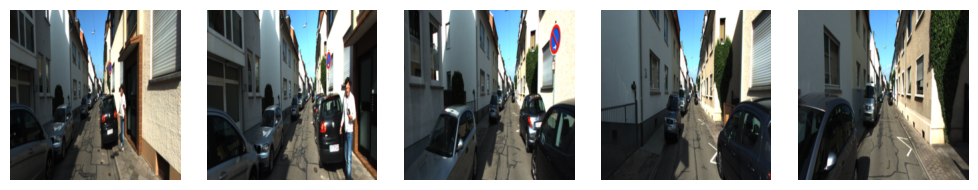

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from dataset import KITTIDataset
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = KITTIDataset(image_dir=train_dir, seq_length=5, transform=transform)
val_dataset = KITTIDataset(image_dir=val_dir, seq_length=5, transform=transform)
train_subset = Subset(train_dataset, list(range(100)))

batch_size = 2
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

def show_image_single(image):
    image = image[0].cpu().detach().permute(1, 2, 0).type(torch.float32).numpy()
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def show_image_frames(dataset, index):
    frames = dataset[index].cpu()
    num_frames = frames.size(0)

    fig, axes = plt.subplots(1, num_frames, figsize=(num_frames * 2, 2))
    for i in range(num_frames):
        image = frames[i].permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# image check
show_image_frames(val_dataset, 300)

In [ ]:
import torch.optim as optim
import math
from project_model import STGN, Upscaler, FeatureExtractor
from torch.utils.data import DataLoader
from project_GAN import Generator, Discriminator
import gc

gc.collect()
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels = 3
image_size = 256

generator = Generator(in_channels=64).to(device)
discriminator = Discriminator(in_channels, image_size).to(device)
feature_extractor = FeatureExtractor().to(device)
stgn = STGN(in_channels=64, hidden_channels=64, time_steps=4).to(device)

adversarial_loss = nn.BCEWithLogitsLoss()
content_loss = nn.MSELoss()

lr = 0.0002
num_epochs = 10
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)


Epoch [1/10]


<ipython-input-26-5409873e8c3e>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # GradScaler


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-26-5409873e8c3e>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # mixed-precision mode
<ipython-input-26-5409873e8c3e>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10], D Loss: 1.0064, G Loss: 0.0768
Epoch [2/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/10], D Loss: 1.0064, G Loss: 0.0800
Epoch [3/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/10], D Loss: 1.0064, G Loss: 0.0831
Epoch [4/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/10], D Loss: 1.0064, G Loss: 0.0812
Epoch [5/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/10], D Loss: 1.0064, G Loss: 0.0740
Epoch [6/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/10], D Loss: 1.0064, G Loss: 0.0815
Epoch [7/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/10], D Loss: 1.0064, G Loss: 0.0808
Epoch [8/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/10], D Loss: 1.0064, G Loss: 0.0793
Epoch [9/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/10], D Loss: 1.0064, G Loss: 0.0797
Epoch [10/10]


Training Batches:   0%|          | 0/50 [00:00<?, ?it/s]

torch.Size([3, 256, 256])


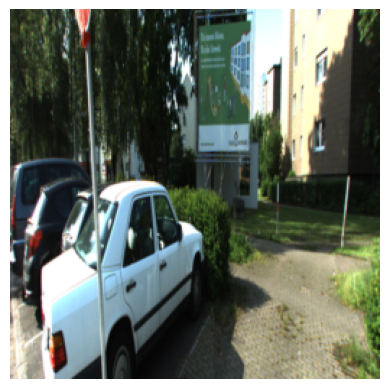

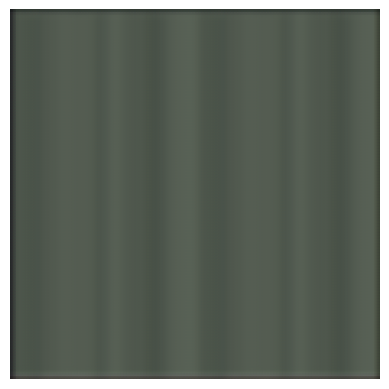

Epoch [10/10], D Loss: 1.0064, G Loss: 0.0891


In [ ]:
from tqdm.notebook import tqdm
scaler = torch.cuda.amp.GradScaler()  # GradScaler

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training Batches", leave=False)):
        # data load
        frames = batch[:, :-1, :, :, :].to(device)
        high_res = batch[:, -1, :, :, :].to(device)

        # feature extracting
        data_list_seq = []
        for t in range(frames.size(1)):
            feature_map = feature_extractor(frames[:, t])
            data_list = feature_map_to_graph(feature_map)
            data_list_seq.extend(data_list)

        with torch.cuda.amp.autocast():  # mixed-precision mode
            gen_hr = stgn(data_list_seq)
            # generator
            gen_hr = generator(gen_hr)

            # discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(high_res.size(0), 1).to(device)
            fake_labels = torch.zeros(high_res.size(0), 1).to(device)

            # GAN calculation
            real_outputs = discriminator(high_res)
            d_loss_real = adversarial_loss(real_outputs, real_labels)

            fake_outputs = discriminator(gen_hr.detach())
            d_loss_fake = adversarial_loss(fake_outputs, fake_labels)

            # backprop_D
            d_loss = d_loss_real + d_loss_fake

        # Scaled backward for discriminator
        scaler.scale(d_loss).backward()
        scaler.step(optimizer_D)
        scaler.update()

        # backprop_G
        optimizer_G.zero_grad()
        with torch.cuda.amp.autocast():
            gen_outputs = discriminator(gen_hr)
            g_loss_content = content_loss(gen_hr, high_res)
            g_loss_adversarial = adversarial_loss(gen_outputs, real_labels)
            g_loss = g_loss_content + 1e-3 * g_loss_adversarial

        # Scaled backward for generator
        scaler.scale(g_loss).backward()
        scaler.step(optimizer_G)
        scaler.update()

        torch.cuda.empty_cache()

        if epoch == num_epochs - 1 and batch_idx == len(train_loader) - 1:
            print(high_res[0].size())
            show_image_single(high_res)
            show_image_single(gen_hr)


    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
